# Covariates - Population

In this notebook, we'll analyze and try to model the behavior of the `Population` variable, that'll be used as an explanatory variable to our final model.

In [10]:
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf
import pandas as pd

from utils import get_filtered_data, create_future_dataframe, plot_series

In [15]:
#Reading the data
df = get_filtered_data()

#Creating Test DataFrame for Future Predictions 
test_df = create_future_dataframe()

## Visualizing the Data

The `Population` variable presents a very linear beahvior. 
Definetely a linear model is the best choice but as we can see there seems to be a slightly slope change after 2020. 

With that in mind, a PieceWise Regression seems to be the best option.

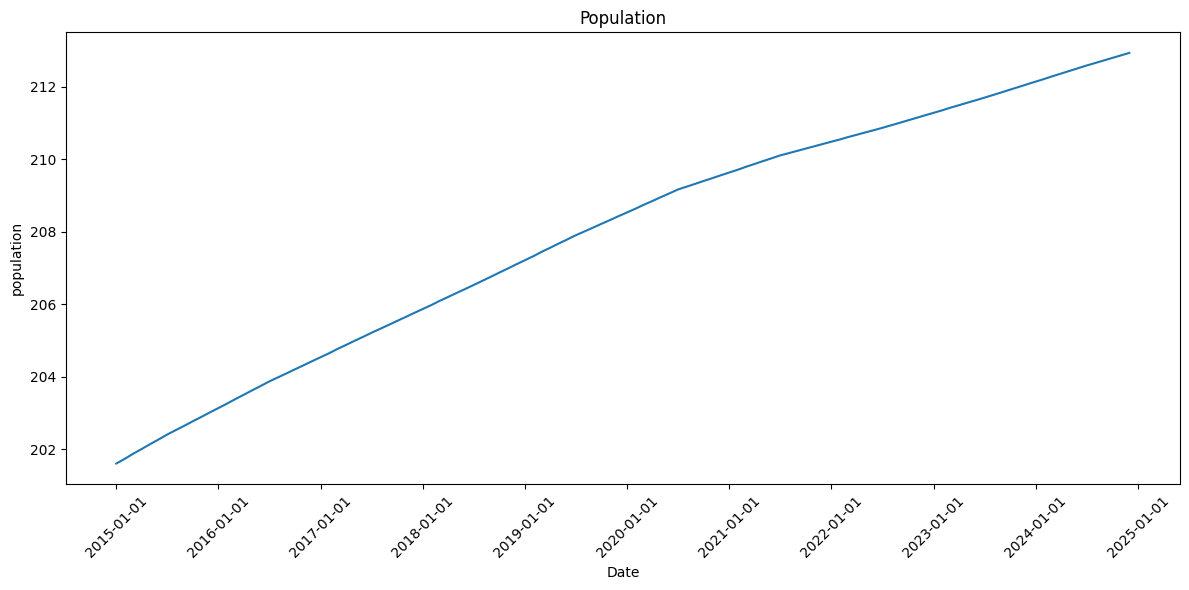

In [4]:
population = df[['date', 'population']] 
plot_series(population, 'population')

Let's take a look at the data to verify where this step that seems to have changed the slope occured.

When can see it by simple computing the tangent at each interval, which is simply the $\Delta y$

## Computing the First Differences

In [6]:
pop_tangent = population[['date', 'population']] 
pop_tangent['diff'] = pop_tangent['population'].diff(1) 

In [7]:
pop_tangent[pop_tangent["date"].dt.year > 2019]

,date,population,diff
156,2020-01-01,208.532494,0.105399
157,2020-02-01,208.637893,0.105399
158,2020-03-01,208.743292,0.105399
159,2020-04-01,208.848692,0.105399
160,2020-05-01,208.954091,0.105399
161,2020-06-01,209.059490,0.105399
162,2020-07-01,209.164889,0.105399
163,2020-08-01,209.243118,0.078229
164,2020-09-01,209.321348,0.078229
165,2020-10-01,209.399577,0.078229


### Nice Pattern

There's a very interesting pattern here. The population changes its growth rate basically every August, for this dataset. 
With that in mind, we can set the first knot to `2020-08-01` and we might get a nice result.

## Model Fit

In [18]:
population = (
    population
    .assign(
        t = range(len(population)),
        month = population["date"].dt.month
    )
)

### Classical OLS and Stepwise Regression

In [19]:
model_ols_population = smf.ols("population ~ t + C(month)", data=population).fit()

# ----- Model 2: Piecewise Trend + Season -----
knot_date = pd.to_datetime("2020-08-01")
knot_t = population.loc[population["date"] == knot_date, "t"].iloc[0]

# piecewise variable: 0 before knot, (t - knot) after
population["t_knot"] = (population["t"] - knot_t).clip(lower=0)

model_stepwise_population = smf.ols("population ~ t + t_knot + C(month)", data=population).fit()

### OLS Results

In [20]:
model_ols_population.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             population   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     677.9
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           5.20e-95
Time:                        12:25:35   Log-Likelihood:                -52.907
No. Observations:                 120   AIC:                             131.8
Df Residuals:                     107   BIC:                             168.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        202.3329      0.138   1463.922      0.000     202.059     202.607
C(month)[T.2]      0.0035      0.178      0.019      0.985      -0.350       0.357
C(month)[T.3]      0.0069      0.178      0.039      0.969      -0.346       0.360
C(month)[T.4]      0.0104      0.178      0.058      0.954      -0.343       0.363
C(month)[T.5]      0.0138      0.178      0.078      0.938      -0.339       0.367
C(month)[T.6]      0.0173      0.178      0.097      0.923      -0.336       0.370
C(month)[T.7]      0.0207      0.178      0.116      0.908      -0.333       0.374
C(month)[T.8]      0.0179      0.178      0.100      0.920      -0.335       0.371
C(month)[T.9]      0.0150      0.178      0.084      0.933      -0.338       0.368
C(month)[T.10]     0.0122      0.178      0.068      0.946      -0.341       0.366
C(month)[T.11]     0.0094      0.178      0.053      0.958      -0.344       0.363
C(month)[T.12]     0.0065      0.178      0.037      0.971      -0.347       0.360
t                  0.0947      0.001     89.740      0.000       0.093       0.097
==============================================================================
Omnibus:                       39.347   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.462
Skew:                          -0.170   Prob(JB):                       0.0240
Kurtosis:                       1.827   Cond. No.                         857.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Stepwise Results

In [21]:
model_stepwise_population.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             population   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.432e+04
Date:                Tue, 30 Sep 2025   Prob (F-statistic):          1.56e-191
Time:                        12:25:36   Log-Likelihood:                 202.50
No. Observations:                 120   AIC:                            -377.0
Df Residuals:                     106   BIC:                            -338.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        201.7700      0.018   1.13e+04      0.000     201.735     201.805
C(month)[T.2]      0.0032      0.021      0.149      0.882      -0.039       0.045
C(month)[T.3]      0.0063      0.021      0.297      0.767      -0.036       0.049
C(month)[T.4]      0.0095      0.021      0.446      0.656      -0.033       0.052
C(month)[T.5]      0.0127      0.021      0.595      0.553      -0.030       0.055
C(month)[T.6]      0.0158      0.021      0.743      0.459      -0.026       0.058
C(month)[T.7]      0.0190      0.021      0.892      0.374      -0.023       0.061
C(month)[T.8]      0.0159      0.021      0.745      0.458      -0.026       0.058
C(month)[T.9]      0.0172      0.021      0.805      0.422      -0.025       0.059
C(month)[T.10]     0.0185      0.021      0.866      0.389      -0.024       0.061
C(month)[T.11]     0.0198      0.021      0.926      0.357      -0.023       0.062
C(month)[T.12]     0.0210      0.021      0.986      0.326      -0.021       0.063
t                  0.1126      0.000    461.333      0.000       0.112       0.113
t_knot            -0.0441      0.001    -85.880      0.000      -0.045      -0.043
==============================================================================
Omnibus:                       24.313   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.492
Skew:                          -1.078   Prob(JB):                     8.80e-08
Kurtosis:                       4.359   Cond. No.                         884.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Visualizing the Models Fit

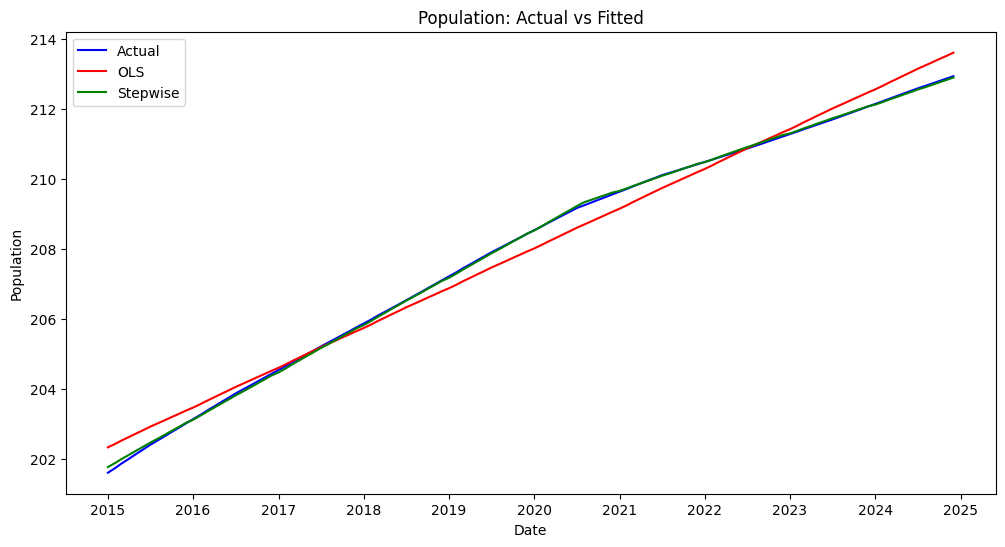

In [22]:
population['ols'] = model_ols_population.fittedvalues 
population['stepwise'] = model_stepwise_population.fittedvalues

# Plot actual vs fitted
plt.figure(figsize=(12, 6))
plt.plot(population["date"], population["population"], label="Actual", color="blue")
plt.plot(population["date"], population["ols"], label="OLS", color="red")
plt.plot(population["date"], population["stepwise"], label="Stepwise", color="green")

plt.title("Population: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Population")
plt.legend()
plt.show()

Stepwise regression does a Perfect Job! 

### Visualizing Test Predictions

In [23]:
#adding the t_knot exog variable to the test set 
test_df["t_knot"] = (test_df["t"] - knot_t).clip(lower=0)

population_preds = model_stepwise_population.predict(test_df) 
test_df['population'] = population_preds

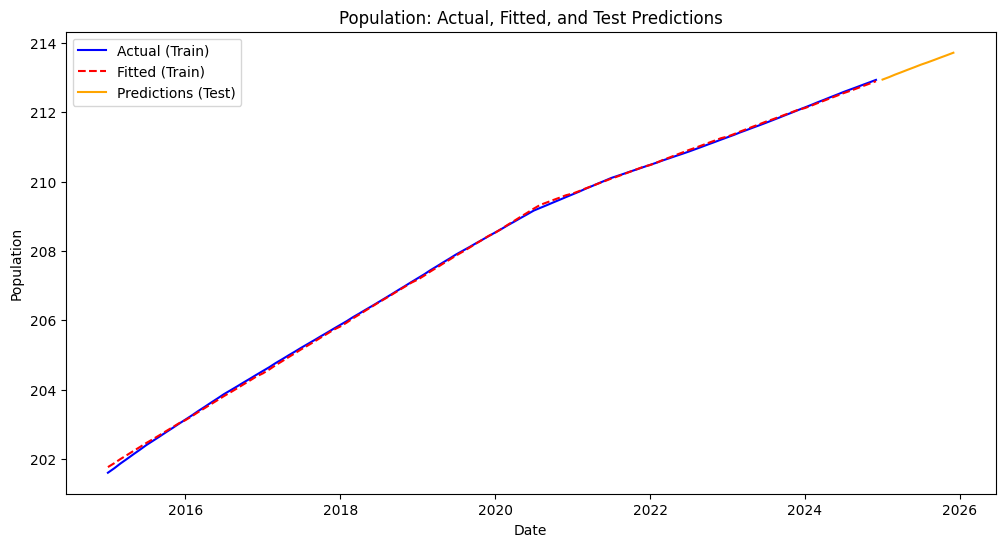

In [24]:
# Plot
plt.figure(figsize=(12, 6))

# Actual (train only)
plt.plot(population["date"], population["population"],
         label="Actual (Train)", color="blue") 

# Fitted (train only)
plt.plot(population["date"], population["stepwise"],
         label="Fitted (Train)", color="red", linestyle="--")

# Predictions (test only)
plt.plot(test_df["date"], test_df["population"],
         label="Predictions (Test)", color="orange")

plt.title("Population: Actual, Fitted, and Test Predictions")
plt.xlabel("Date")
plt.ylabel("Population")
plt.legend()
plt.show()

## Saving the Predictions

In [26]:
test_df[['date', 'population']].to_csv("../../predictions/2025_population.csv", index=False)

In [27]:
test_df[['date', 'population']]

,date,population
0,2025-01-01,212.941754
1,2025-02-01,213.013372
2,2025-03-01,213.084990
3,2025-04-01,213.156609
4,2025-05-01,213.228227
5,2025-06-01,213.299845
6,2025-07-01,213.371463
7,2025-08-01,213.436788
8,2025-09-01,213.506527
9,2025-10-01,213.576266
